In [20]:
from rpy2 import robjects
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import datetime
import yaml
import os

# Convert pandas dataframe
from rpy2.robjects import pandas2ri
pandas2ri.activate()

output_dir = 'output_13-23-fixed/'
#output_dir = 'output_12-10-gammaI/'

dept_avail = os.listdir(output_dir)


rainfall = pd.read_csv('haiti-data/fromAzman/rainfall.csv', index_col = 0, parse_dates = True)
cases    = pd.read_csv('haiti-data/fromAzman/cases_corrected.csv', index_col=0, parse_dates =True)


compartments = ['S', 'I', 'A', 'RA1', 'RA2', 'RA3', 'RI1', 'RI2', 'RI3', 'W', 'B', 'cases', 
                 "VSd", "VRI1d", "VRI2d", "VRI3d", "VRA1d", "VRA2d", "VRA3d",
                 "VSdd", "VRI1dd", "VRI2dd", "VRI3dd", "VRA1dd", "VRA2dd", "VRA3dd",
                 "VSd_alt", "VRI1d_alt", "VRI2d_alt", "VRI3d_alt", "VRA1d_alt", "VRA2d_alt", "VRA3d_alt",
                 "VSdd_alt", "VRI1dd_alt", "VRI2dd_alt", "VRI3dd_alt", "VRA1dd_alt", "VRA2dd_alt", "VRA3dd_alt"]

stream = open('haiti-data/input_parameters.yaml', 'r')
input_parameters = yaml.load(stream)

dept_name = [list(pop.keys())[0] for pop in input_parameters['population']]

t_start = input_parameters['t_start']
t_for = datetime.date(2029,12,21)

# computes precipitation sample
def project_rain(rainfall, tf):
    nd = 14 #days sampled - must be multiple of 7 d
    
    dti = rainfall.iloc[0].name.date()
    dtf = rainfall.iloc[-1].name.date()
    
    rain_prj_index = pd.DatetimeIndex(start =  dtf + datetime.timedelta(1), 
                                      end = tf, freq = 'D')
    rain_prj = np.zeros((rain_prj_index.shape[0], 10))

    # Full years of data available
    years = range(dti.year+1, dtf.year-1)

    # each nd days, assign an al precipitation.
    for i, date in enumerate(pd.date_range(dtf + datetime.timedelta(1), tf, freq = str(nd)+'D')):
        dd = date.day
        if (date.month == 2 and dd == 29):
            dd = 28
        pick = datetime.date(np.random.choice(years), date.month, dd)
        #print(pick, i, rainfall.loc[pd.date_range(pick, pick + datetime.timedelta(nd-1))].values.shape, rain_prj[nd * i: nd * (i+1)].shape)
        rain_prj[nd * i: nd * (i+1)] = rainfall.loc[pd.date_range(pick, pick + datetime.timedelta(nd-1))].values

    rain_prj = pd.DataFrame(rain_prj, index = rain_prj_index, columns = dept_name)
    
    return rain_prj

rain_prj = project_rain(rainfall, t_for)
rain = pd.concat((rainfall, rain_prj))
rain.to_csv('haiti-data/proj/rainfall.csv', index_label = 'date')

### Extracting best performing parameters

In [5]:
index = pd.DatetimeIndex(start =  t_start,  end = t_for, freq = 'W-SAT')
r_source = robjects.r['source'];

all_data = {}
#all_params = {}
for i, dp in enumerate(dept_avail):
    dept_data = {}
    robjects.r('departement <- "' + dp + '"')
    robjects.r('output_dir <- "' + output_dir + '"')
    robjects.r('run_level <- 3')
    robjects.r('nsim <- 100')
    robjects.r('t_vacc_start <- "' + str('2010-01-01') + '"')
    robjects.r('t_vacc_end  <- "' + str('2010-01-01') + '"')
    robjects.r('p1d_reg <- 0') 
    robjects.r('r_v_year <- 0')
    print(dp)
    r_source('~/phd/haiti-ocv-pomp/scripts/forecast_haitiOCV.R')
    if i == 0:
        all_params = pd.DataFrame(np.zeros((len(dept_avail), len(robjects.r('names(params)')))),  columns = robjects.r('names(params)'), index = dept_avail) 
    all_params.loc[dp] = robjects.r['params']
    for comp in compartments:
        temp = pandas2ri.ri2py(robjects.r[comp])
        temp.index = index
        temp.drop('date',axis=1, inplace = True)
        dept_data[comp] = temp
    all_data[dp] = dept_data
    #all_params[dp] = params

    

# Convert years in days, 'mu', 'alpha'
rates = [ "gammaI", "gammaA", "rhoA", 'rhoI']
params_disp = all_params.copy()
params_disp.loc[:,'rhoI'] = params_disp.loc[:,'XrhoI'] * params_disp.loc[:,'rhoA']
params_disp.loc[:,'thetaA'] = params_disp.loc[:,'XthetaA'] * params_disp.loc[:,'thetaI']
params_disp.drop(['mu', 'alpha', 'XrhoI', 'XthetaA', 't_vacc_start', 't_vacc_end', 'p1d_reg', 'r_v_year', 'H', 'D', 'Rtot_0'], axis =1, inplace = True)
print(params_disp)
for p in rates:
    params_disp.loc[:,p] =  1/(params_disp.loc[:,p]/365.25)
    
params_disp = params_disp.reindex(columns=sorted(params_disp.columns))

Artibonite


/usr/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: ── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

  warnings.warn(x, RRuntimeWarning)
/usr/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: ✔ ggplot2 3.0.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.6
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0

  warnings.warn(x, RRuntimeWarning)
/usr/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

  warnings.warn(x, RRuntimeWarning)
/usr/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 
Attaching package: ‘magrittr’


  warnings.warn(x, RRuntimeWarning)
/usr/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: The following object i

               sigma     betaB        mu_B    thetaI   lambdaR         r  \
Artibonite  0.175803  2.329518  518.129131  0.000357  0.362278  0.644447   

             gammaI   gammaA       rhoA  foi_add   epsilon           k  \
Artibonite  182.625  182.625  12.254748   0.0007  0.293841  165.245575   

               std_W  cases_ext       rhoI    thetaA  
Artibonite  0.004775        0.0  10.743893  0.000008  


/usr/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


In [19]:
params_disp

,betaB,cases_ext,epsilon,foi_add,gammaA,gammaI,k,lambdaR,mu_B,r,rhoA,rhoI,sigma,std_W,thetaA,thetaI
Artibonite,2.329518,0.0,0.293841,0.0007,2.0,2.0,165.245575,0.362278,518.129131,0.644447,29.804775,33.996058,0.175803,0.004775,0.000008,0.000357


In [18]:
all_params['rhoA']

Artibonite    44.554287
Name: rhoA, dtype: float64

In [16]:
all_params['XrhoI']

Artibonite    0.62269
Name: XrhoI, dtype: float64

In [17]:
0.62269*44.554287

27.74350897203

In [ ]:
import seaborn as sns


sns.pairplot(params_disp, markers = '.')

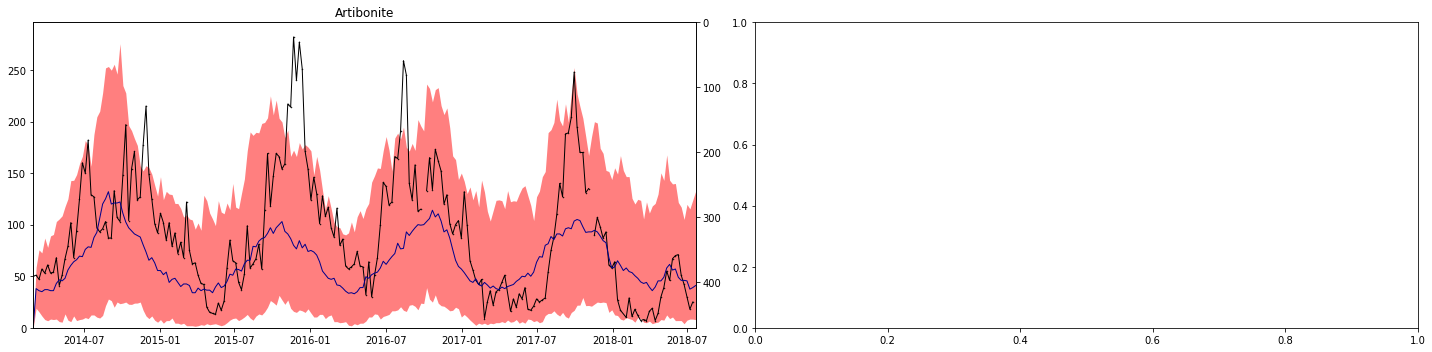

In [9]:
ti = input_parameters['t_start']
tf = datetime.date(2018,7,21)

fig, axes = plt.subplots((len(all_data))//2+1, 2, figsize=(20,5), squeeze = True);
fig.patch.set_facecolor('white')
axes = axes.flatten();
for i, dp in enumerate(dept_avail):
    axt =  axes[i].twinx()
    axes[i].plot(cases[dp][t_start:][ti:tf], marker='.', linestyle='-',color='k', linewidth=1, markersize=1 ) 
    axes[i].fill_between(all_data[dp]['cases']['q05'][ti:tf].index, all_data[dp]['cases']['q05'][ti:tf], all_data[dp]['cases']['q95'][ti:tf], alpha = .5, color = 'red', linewidth = 0)
    #axes[i].plot(all_data[dp]['cases']['mean'], linewidth=1, alpha = 1,linestyle='-.', color = 'black')
    axes[i].plot(all_data[dp]['cases']['q50'][ti:tf], alpha = 1,linestyle='-', linewidth = 1, color = 'darkblue')
    #axt.bar(pd.date_range(t_start,t_for, freq='W-SAT')[ti:tf].date, rain[dp].resample('W-SAT').sum()[t_start:t_for][ti:tf], 
    #            label = r'Rainfall', color = 'darkblue', width=7, alpha = 1)

    axes[i].set_title(dp)
    axes[i].set_ylim(0)
    axt.set_ylim(2*max(rain[dp].resample('W-SAT').sum()[t_start:t_for]),0) # check if only reverse y
    axes[i].set_xlim(ti, tf)
    #axes[i].legend()
    
fig.tight_layout()

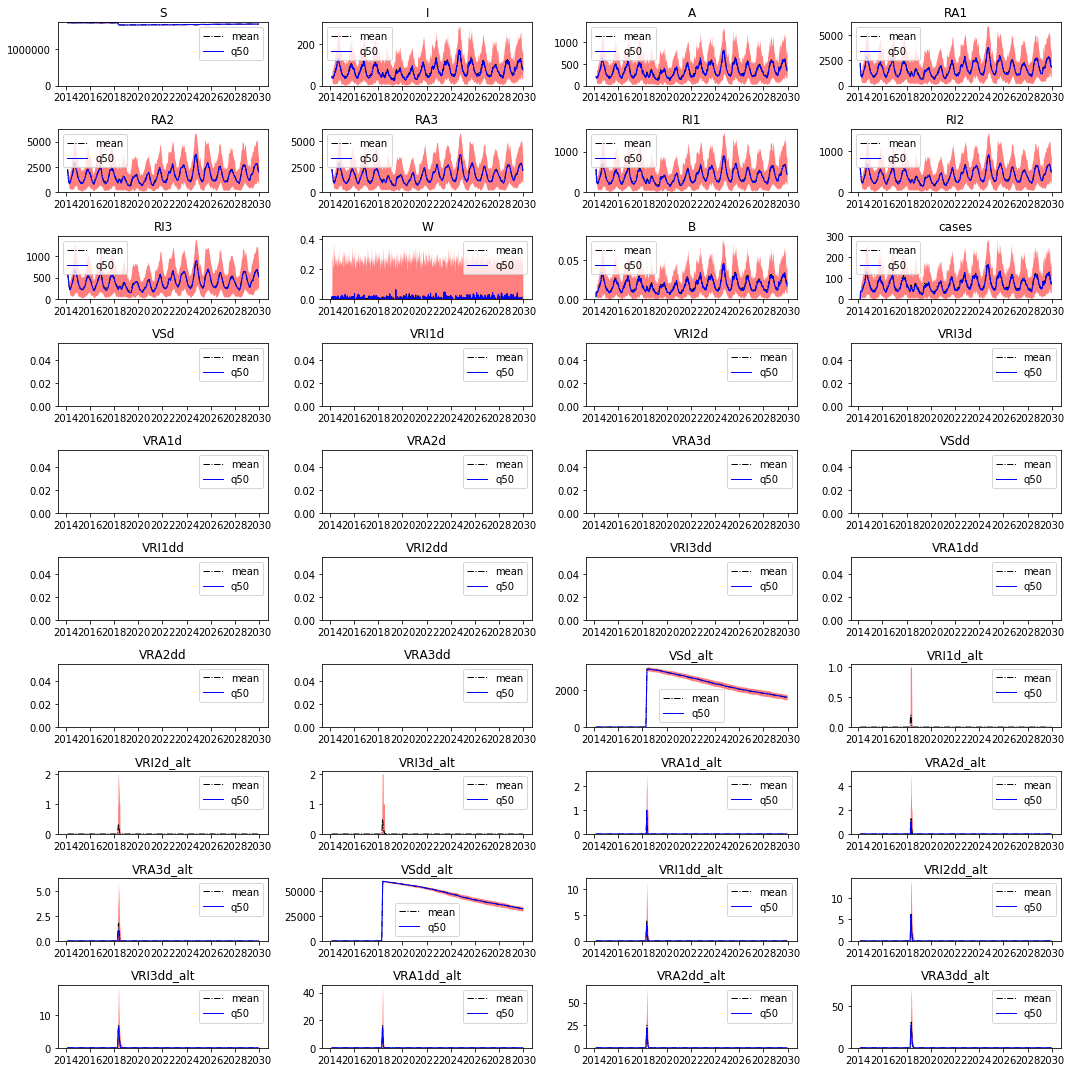

In [10]:
dp = 'Artibonite'
fig, axes = plt.subplots((len(compartments))//4, 4, figsize=(15,15), squeeze = True);
axes = axes.flatten();
for i, comp in enumerate(compartments):
    axes[i].fill_between(all_data[dp][comp]['q05'].index, all_data[dp][comp]['q05'], all_data[dp][comp]['q95'], alpha = .5, color = 'red', linewidth = 0)
    axes[i].plot(all_data[dp][comp]['mean'], linewidth=1, alpha = 1,linestyle='-.', color = 'black')
    axes[i].plot(all_data[dp][comp]['q50'], alpha = 1,linestyle='-', linewidth = 1, color = 'blue') 
    axes[i].set_title(comp)
    axes[i].legend()
    axes[i].set_ylim(0)
    
fig.tight_layout()

In [21]:
class VaccinationScenario():

    def __init__(self, course_year, percent_completely_unvaccinated, percent_onedose, percent_twodoses, not_dep = []):
        pop = {'Artibonite':1727524,
        'Centre':746236,
        'Grande_Anse':468301,
        'Nippes':342525,
        'Nord':1067177,
        'Nord-Est':393967,
        'Nord-Ouest':728807,
        'Ouest':4029705,
        'Sud':774976,
        'Sud-Est':632601}

        ocv_order = ['Centre', 'Artibonite','Ouest','Nord-Ouest','Nord','Sud', 'Nippes','Nord-Est', 'Sud-Est','Grande_Anse']


        self.t_vacc_start = {}
        self.t_vacc_end = {}
        self.p1d_reg = {}
        self.r_v_year = {}

        #20% completely unvaccinated, 10% one-dose only, 70% two doses

        t_init = datetime.date(2018,7,14)
        days_per_departement = int((course_year*365)/len(ocv_order))

        for i, dp in enumerate(ocv_order):
            if dp not in not_dep:
                self.t_vacc_start[dp] = t_init + datetime.timedelta(days=i*days_per_departement)
                self.t_vacc_end[dp] = t_init + datetime.timedelta(days=(i+1)*days_per_departement)
                self.p1d_reg[dp] = percent_onedose/(percent_onedose + percent_twodoses)
                self.r_v_year[dp] = pop[dp]*(100-percent_completely_unvaccinated)/100/days_per_departement * 365.25

            else:
                self.t_vacc_start[dp] = t_init + datetime.timedelta(days=i*days_per_departement)
                self.t_vacc_end[dp] = t_init + datetime.timedelta(days=(i+1)*days_per_departement)
                self.p1d_reg[dp] = 0
                self.r_v_year[dp] =0



S1 = VaccinationScenario(2, 20, 10, 70)
S2 = VaccinationScenario(2, 40, 20, 40, not_dep=['Ouest','Nord-Ouest','Sud', 'Nippes','Nord-Est', 'Sud-Est','Grande_Anse'])
S3 = VaccinationScenario(5, 3.33, 1.67, 95)

In [ ]:
# Running simulation:
scenario = S1
index = pd.DatetimeIndex(start =  t_start,  end = t_for, freq = 'W-SAT')
r_source = robjects.r['source'];

all_data_vacc = {}
for i, dp in enumerate(dept_avail):
    dept_data = {}
    robjects.r('departement <- "' + dp + '"')
    robjects.r('output_dir <- "' + output_dir + '"')
    robjects.r('run_level <- 3')
    robjects.r('nsim <- 100')
    
    robjects.r('t_vacc_start <- "' + str(scenario.t_vacc_start[dp]) + '"')
    robjects.r('t_vacc_end  <- "' + str(scenario.t_vacc_end[dp]) + '"')
    robjects.r('p1d_reg <- ' + str(scenario.p1d_reg[dp]))
    robjects.r('r_v_year <- ' + str(scenario.r_v_year[dp]))

    r_source('~/phd/haiti-ocv-pomp/scripts/forecast_haitiOCV.R')
  
    for comp in compartments:
        temp = pandas2ri.ri2py(robjects.r[comp])
        temp.index = index
        temp.drop('date',axis=1, inplace = True)
        dept_data[comp] = temp
    all_data_vacc[dp] = dept_data
    #all_params[dp] = params

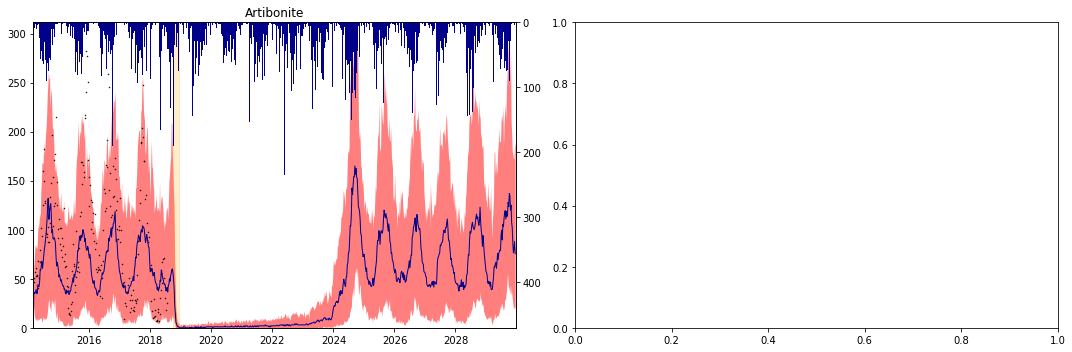

In [18]:
fig, axes = plt.subplots((len(all_data))//2+1, 2, figsize=(15,5), squeeze = True);
axes = axes.flatten();
fig.patch.set_facecolor('white')


for i, dp in enumerate(dept_avail):
    axt =  axes[i].twinx()
    axes[i].plot(cases[dp][t_start:], marker='.', linestyle='-',color='k', linewidth=0, markersize=1 ) 
    axes[i].fill_between(all_data_vacc[dp]['cases']['q05'].index, all_data_vacc[dp]['cases']['q05'], all_data_vacc[dp]['cases']['q95'], alpha = .5, color = 'red', linewidth = 0)
    axes[i].plot(all_data_vacc[dp]['cases']['q50'], alpha = 1,linestyle='-', linewidth = 1, color = 'darkblue')
    axt.bar(pd.date_range(t_start,t_for, freq='W-SAT').date, rain[dp].resample('W-SAT').sum()[t_start:t_for], 
                label = r'Rainfall', color = 'darkblue', width=7, alpha = 1)

    axes[i].set_title(dp)
    axes[i].set_ylim(0)
    axt.set_ylim(2*max(rain[dp].resample('W-SAT').sum()[t_start:t_for]),0) # check if only reverse y
    axes[i].set_xlim(t_start, t_for)
    #axes[i].legend()
    

    # convert to matplotlib date representation
    start = mdates.date2num(scenario.t_vacc_start[dp])
    end = mdates.date2num(scenario.t_vacc_end[dp])
    width = end - start
    rect = Rectangle((start, 0), width, 100+max(all_data_vacc[dp]['cases']['q95']), color='orange', alpha= 0.1)
    axes[i].add_patch(rect) 
    axes[i].add_artist(rect)
    rx, ry = rect.get_xy()
    cx = rx + rect.get_width()/2.0
    cy = ry + rect.get_height()/1.5
    #axes[i].annotate(r'Vaccination', (cx, cy), color='black',# weight='bold', 
    #            fontsize=12, ha='center', va='center', rotation='vertical')

fig.tight_layout()

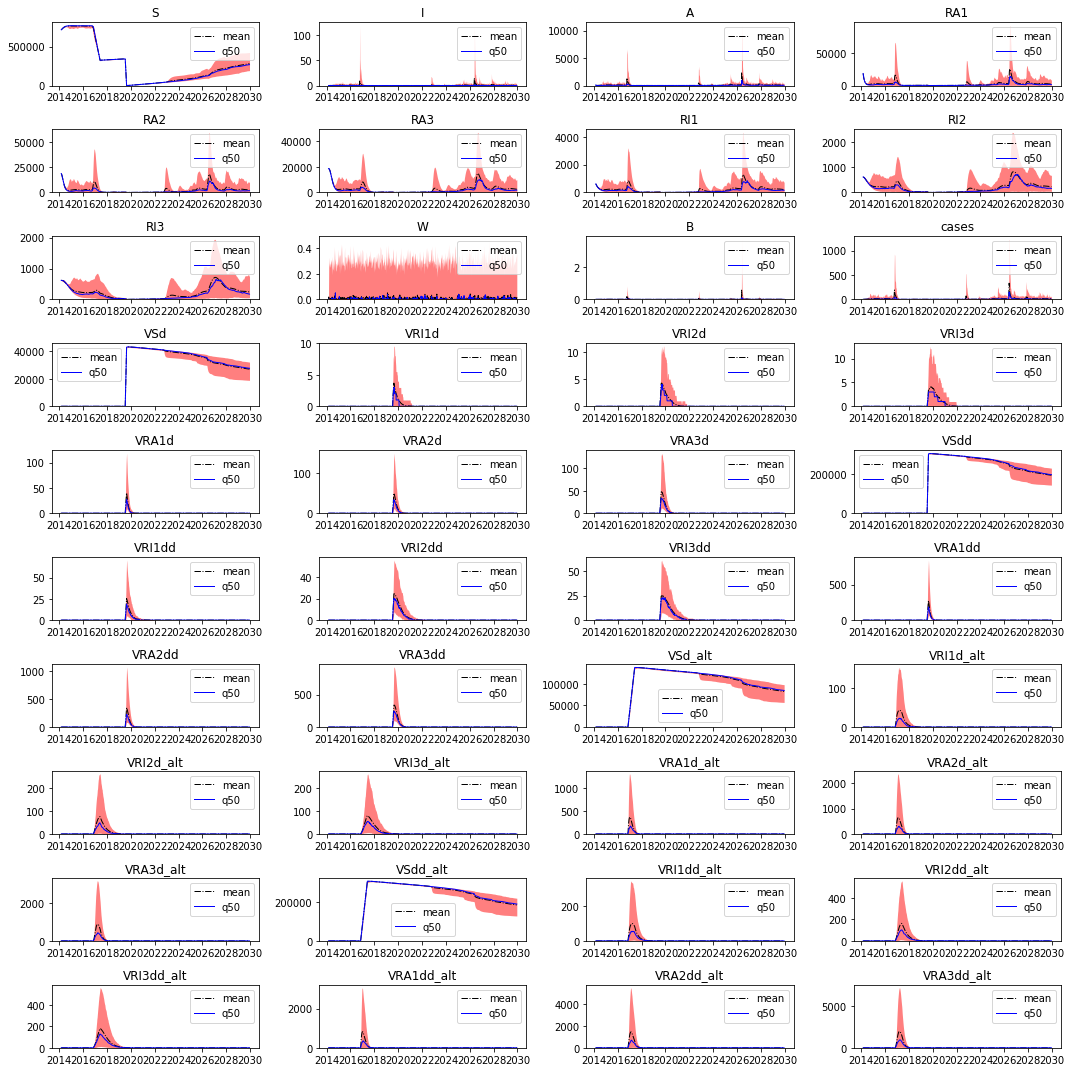

In [179]:
dp = 'Sud'


fig, axes = plt.subplots((len(compartments))//4, 4, figsize=(15,15), squeeze = True);
axes = axes.flatten();
for i, comp in enumerate(compartments):
    axes[i].fill_between(all_data_vacc[dp][comp]['q05'][ti:tf].index, all_data_vacc[dp][comp]['q05'][ti:tf], all_data_vacc[dp][comp]['q95'][ti:tf], alpha = .5, color = 'red', linewidth = 0)
    axes[i].plot(all_data_vacc[dp][comp]['mean'][ti:tf], linewidth=1, alpha = 1,linestyle='-.', color = 'black')
    axes[i].plot(all_data_vacc[dp][comp]['q50'][ti:tf], alpha = 1,linestyle='-', linewidth = 1, color = 'blue') 
    axes[i].set_title(comp)
    axes[i].legend()
    axes[i].set_ylim(0)
    
fig.tight_layout()

In [11]:
all_data[dp]['I']['q50']

2014-03-01    406.0
2014-03-08     34.0
2014-03-15     43.5
2014-03-22     83.5
2014-03-29    104.0
2014-04-05    138.0
2014-04-12    146.5
2014-04-19    215.5
2014-04-26    189.0
2014-05-03    244.0
2014-05-10    224.0
2014-05-17    318.5
2014-05-24    347.5
2014-05-31    358.0
2014-06-07    364.0
2014-06-14    345.5
2014-06-21    439.0
2014-06-28    393.0
2014-07-05    477.5
2014-07-12    506.5
2014-07-19    422.0
2014-07-26    566.5
2014-08-02    570.0
2014-08-09    510.5
2014-08-16    594.5
2014-08-23    532.5
2014-08-30    680.0
2014-09-06    581.5
2014-09-13    568.0
2014-09-20    595.0
              ...  
2029-05-26    578.5
2029-06-02    511.0
2029-06-09    529.5
2029-06-16    568.0
2029-06-23    516.0
2029-06-30    497.5
2029-07-07    513.0
2029-07-14    552.0
2029-07-21    618.5
2029-07-28    519.5
2029-08-04    490.5
2029-08-11    487.0
2029-08-18    576.0
2029-08-25    499.0
2029-09-01    537.0
2029-09-08    539.5
2029-09-15    502.0
2029-09-22    533.0
2029-09-29    568.0
